### ML3 HW3
#### LT5
Borromeo, Chloe<br>
Castanares, Michael<br>
Garcia, Fernando Jude<br>
Tan, Allan

Assignment Instructions<br>
Done by LT<br>
Total: 12 points<br>
Submit: Python Notebook (.ipynb)<br>
Task (4pts each method)<br>
Hourly Energy Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region<br>

Using the PJM West Region: 2001-2018 (PJMW) estimated hourly energy consumption data from PJM in Megawatts: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data. Forecast the total daily consumption one month in advance. Compare the MAE and MAPE accuracy of the best:<br><br>
ARIMA<br>
LSTM<br>
GRU<br>

### Load the data

In [2]:
import pandas as pd

In [3]:
file = 'data/PJMW_hourly.csv'

In [12]:
df = pd.read_csv(file)
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [13]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


Resample to get daily consumption

In [ ]:

df.index = pd.to_datetime(df['Datetime'])
df_daily = df.resample('D').sum('PJMW_MW')

# print(df_daily)

# Stabilize seasonality
# standardize to 30 days
# Comment the succeeding parts out if not needed and simply use df_daily[:-1]

day_31_list = []
for item in df_daily.index:
    # print(item)
    if str(item).split(' ')[0].endswith('31'):
        day_31_list.append(item)
df_daily_30 = df_daily.loc[~df_daily.index.isin(day_31_list)]
# print(df_daily_30)


# Remove February because it only has 28/29 days?
feb_list = []
for item in df_daily_30.index:
    # print(item)
    if '-02-' in (str(item).split(' ')[0]):
        feb_list.append(item)

df_daily_30 = df_daily_30.loc[~df_daily_30.index.isin(feb_list)]

# # Remove Aug 3 2018 because it does not have a complete day's worth of data?
print(df_daily_30)

df_daily_30 = df_daily_30[:-1]

print(df_daily_30)


             PJMW_MW
Datetime            
2002-04-01  121237.0
2002-04-02  127450.0
2002-04-03  127822.0
2002-04-04  136099.0
2002-04-05  136467.0
...              ...
2018-07-29  127052.0
2018-07-30  131825.0
2018-08-01  143033.0
2018-08-02  139321.0
2018-08-03    5489.0

[5403 rows x 1 columns]
             PJMW_MW
Datetime            
2002-04-01  121237.0
2002-04-02  127450.0
2002-04-03  127822.0
2002-04-04  136099.0
2002-04-05  136467.0
...              ...
2018-07-28  131659.0
2018-07-29  127052.0
2018-07-30  131825.0
2018-08-01  143033.0
2018-08-02  139321.0

[5402 rows x 1 columns]


### 1. ARIMA

In [112]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


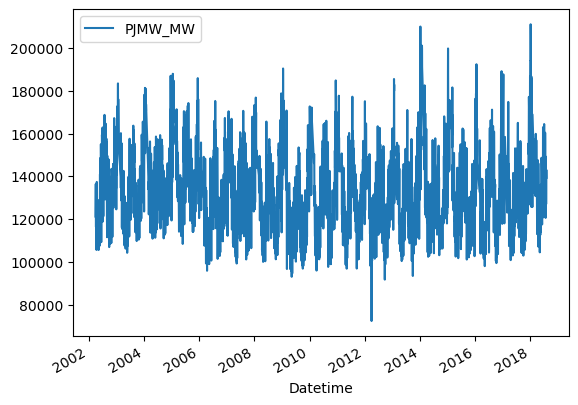

In [113]:
from matplotlib import pyplot
%matplotlib inline
df_daily_30.plot()
pyplot.show()

The data needs to be stationary for ARIMA to work. Let's check that.

In [ ]:
# ! conda install statsmodels -y

Channels:
 - defaults
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/andy/miniconda3/envs/gpu

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2025.1.31          |  py312h06a4308_0         162 KB
    patsy-1.0.1                |  py312h06a4308_0         356 KB
    statsmodels-0.14.4         |  py312h5eee18b_0        12.1 MB
    ------------------------------------------------------------
                                           Total:        12.6 MB

The following NEW packages will be INSTALLED:

  bottleneck         pkgs/main/linux-64::bottleneck-1.4.2-py312ha883a20_0 
  numexpr            pkgs/main/linux-64::numexpr-2.10.1-py312h3c60e43_0 
  pandas             pkgs/main/linux-64::pandas-2.2.3-py312h6a678d5_0 
  patsy              pkgs/main/linux-64

In [114]:
from statsmodels.tsa.stattools import adfuller

series = df_daily_30['PJMW_MW']
# Perform the ADF test to check stationarity
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.167066
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


The results show that the test statistic value -8.167066 is smaller than the critical value at 1% of -3.432. This suggests the process has no unit root, and in turn that **the time series is stationary or does not have time-dependent structure**.

In [115]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm 
import timeit

# Create a differenced series
def difference(dataset, interval=1):
    diff = np.diff(dataset, n=interval)
    return diff

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
   return yhat + history[-interval]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    #X = X.astype('float32')
    days_in_a_month = 30  # Define the number of hours in a day
    train_size = int(len(X) - days_in_a_month)  # Use 1 month validation
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #history = list(train)
    days_in_a_month = 30  # Define the number of hours in a day

    # Make predictions
    predictions = list()
    for t in tqdm(range(len(test))):
        # Difference data
        diff = difference(history, days_in_a_month)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean[0]
        yhat = inverse_difference(history, yhat, days_in_a_month)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Calculate out-of-sample error (RMSE)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    #print(test)
    #print(predictions)
    return rmse


Take the last 3 years of the data and get a baseline RMSE

In [116]:
# X = series.values[:3*365]
X = series.values
start = timeit.default_timer()
rmse = evaluate_arima_model(X, (0, 0, 1))
exec_time = timeit.default_timer() - start
print(f'RMSE={rmse} Execution Time: {exec_time}')


100%|██████████| 30/30 [00:12<00:00,  2.32it/s]

RMSE=13079.995987376476 Execution Time: 12.93157099200107


Do GridSearch to find the optimal values of p,d and q

In [118]:
from itertools import product

# Define ranges for p, d, q
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

# Initialize a dictionary to store the results
results = {}
start = timeit.default_timer()
# Iterate over all combinations of p, d, q
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    # Evaluate the ARIMA model for the current (p, d, q) order
    try:
        rmse = evaluate_arima_model(X, order)
        # Store the result in the dictionary
        results[order] = rmse
        print(f"Order {order}, RMSE: {rmse}")
    except:
        print(f"Error trying to converge Order {order}")

# Find the (p, d, q) combination with the lowest RMSE
best_order = min(results, key=results.get)
best_rmse = results[best_order]
exec_time = timeit.default_timer() - start
# Print the best (p, d, q) combination and the corresponding RMSE
print(f"\nBest Order: {best_order}, Lowest RMSE: {best_rmse}, Execution Time: {exec_time}")

100%|██████████| 30/30 [00:03<00:00,  8.14it/s]


Order (0, 0, 0), RMSE: 20840.481136540486


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Order (0, 0, 1), RMSE: 13079.995987376476


100%|██████████| 30/30 [00:08<00:00,  3.34it/s]


Order (0, 0, 2), RMSE: 12976.960479577787


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Order (0, 0, 3), RMSE: 12928.90792008214


100%|██████████| 30/30 [00:01<00:00, 22.33it/s]


Order (0, 1, 0), RMSE: 15526.999977458621


100%|██████████| 30/30 [00:04<00:00,  6.36it/s]


Order (0, 1, 1), RMSE: 14654.822793796215


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


Order (0, 1, 2), RMSE: 12443.951637709357


100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


Order (0, 1, 3), RMSE: 12751.142491841232


100%|██████████| 30/30 [00:04<00:00,  7.06it/s]


Order (1, 0, 0), RMSE: 14357.084038357203


100%|██████████| 30/30 [00:09<00:00,  3.17it/s]


Order (1, 0, 1), RMSE: 12521.681371358109


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


Order (1, 0, 2), RMSE: 12752.048685677682


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Order (1, 0, 3), RMSE: 12549.691679881505


100%|██████████| 30/30 [00:02<00:00, 14.61it/s]


Order (1, 1, 0), RMSE: 15455.720707662673


100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


Order (1, 1, 1), RMSE: 14014.887698628454


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


Order (1, 1, 2), RMSE: 12463.831997941308


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


Order (1, 1, 3), RMSE: 12765.122951941748


100%|██████████| 30/30 [00:05<00:00,  5.80it/s]


Order (2, 0, 0), RMSE: 13688.936295974116


100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


Order (2, 0, 1), RMSE: 12688.920211736984


100%|██████████| 30/30 [00:33<00:00,  1.10s/it]


Order (2, 0, 2), RMSE: 12742.600748086752


100%|██████████| 30/30 [00:46<00:00,  1.54s/it]


Order (2, 0, 3), RMSE: 12562.369051718599


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Order (2, 1, 0), RMSE: 13173.453379485616


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Order (2, 1, 1), RMSE: 13398.869060445893


100%|██████████| 30/30 [01:13<00:00,  2.45s/it]


Order (2, 1, 2), RMSE: 14729.248795409285


 60%|██████    | 18/30 [01:13<00:49,  4.11s/it]


Error trying to converge Order (2, 1, 3)


100%|██████████| 30/30 [00:06<00:00,  4.86it/s]


Order (3, 0, 0), RMSE: 12725.545170485631


100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Order (3, 0, 1), RMSE: 13189.462890703442


100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


Order (3, 0, 2), RMSE: 12553.318513437203


100%|██████████| 30/30 [01:21<00:00,  2.72s/it]


Order (3, 0, 3), RMSE: 14173.069031730365


100%|██████████| 30/30 [00:06<00:00,  4.70it/s]


Order (3, 1, 0), RMSE: 14278.232336680121


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Order (3, 1, 1), RMSE: 13610.09416186489


100%|██████████| 30/30 [01:31<00:00,  3.05s/it]


Order (3, 1, 2), RMSE: 13032.617318861698


100%|██████████| 30/30 [02:15<00:00,  4.51s/it]

Order (3, 1, 3), RMSE: 15052.990275752847

Best Order: (0, 1, 2), Lowest RMSE: 12443.951637709357, Execution Time: 887.3905452010004
